In [1]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities  import  WikipediaAPIWrapper,ArxivAPIWrapper

In [2]:
api_wwrp_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wwrp_arxiv,description="Query arxiv papers")
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("What is the latest research on quantum computing?")

'Published: 2023-05-23\nTitle: Fast and energy-efficient non-volatile III-V-on-silicon photonic phase shifter based on memristors\nAuthors: Zhuoran Fang, Bassem Tossoun, Antoine Descos, Di Liang, Xue Huang, Geza Kurczveil, Arka Majumdar, Raymond G. Beausoleil\nSummary: Silicon photonics has evolved from lab research to commercial products in the\npast decade as it plays an increasingly crucial role in data communication for\nnext-generation data centers and high performance computing1. Recently,\nprogr'

In [4]:
api_wwraper_wikipedia=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wwraper_wikipedia)
wiki.name

'wikipedia'

In [5]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [6]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

/tmp/ipykernel_120013/3584238.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [7]:
tavily.invoke("Provide me the recent AI news?")

[{'title': 'AI News | Latest AI News, Analysis & Events',
  'url': 'https://www.artificialintelligence-news.com/',
  'content': 'AI News reports on the latest artificial intelligence news and insights. Explore industry trends from the frontline of AI.',
  'score': 0.650934},
 {'title': 'AI News & Artificial Intelligence | TechCrunch',
  'url': 'https://techcrunch.com/category/artificial-intelligence/',
  'content': '### [Observability startup Coralogix becomes a unicorn, eyes India expansion](https://techcrunch.com/2025/06/17/observability-startup-coralogix-becomes-a-unicorn-eyes-india-expansion/)\n\n![Microsoft CEO Satya Nadella speaks during the OpenAI DevDay event on November 06, 2023 in San Francisco, California.](https://techcrunch.com/wp-content/uploads/2023/11/GettyImages-1778706501.jpg?w=666) [...] ### [Meta is reportedly building AI smart glasses with Prada, too](https://techcrunch.com/2025/06/17/meta-is-reportedly-building-ai-smart-glasses-with-prada-too/)\n\n![Intel Headquar

In [8]:
## combine all these tools in the list
tools=[arxiv, wiki, tavily]

In [9]:
## Initialize the LLM Model
from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen-qwq-32b")

In [10]:
llm.invoke("What is AI")

AIMessage(content='\n<think>\nOkay, so I need to explain what AI is. Let me start by recalling what I know. AI stands for Artificial Intelligence. But what exactly does that mean? I think it\'s when machines or computers can perform tasks that usually require human intelligence. But maybe I should break it down more.\n\nFirst, maybe define the term. The user is asking for a definition, so I should start with a basic explanation. But I should also mention different types of AI. I remember hearing terms like "narrow AI" and "general AI." Narrow AI is like the stuff we see today, like voice assistants or recommendation systems. General AI would be more like human-level intelligence, but that\'s not really here yet, right?\n\nThen there\'s the technical side. AI involves things like machine learning, neural networks, and algorithms. Maybe I should explain how AI learns from data. Supervised learning, unsupervised learning, reinforcement learning? Those are part of machine learning, which i

In [11]:
llm_with_tools=llm.bind_tools(tools=tools)

In [12]:
## Execute this call
llm_with_tools.invoke("What is the recent news on AI?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'd41nsbtce', 'function': {'arguments': '{"query":"recent news on AI"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 167, 'prompt_tokens': 270, 'total_tokens': 437, 'completion_time': 0.383338916, 'prompt_time': 0.017420096, 'queue_time': 0.045315012, 'total_time': 0.400759012}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_6b36369676', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4c7bd32e-548c-45e2-907e-869c31017d82-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent news on AI'}, 'id': 'd41nsbtce', 'type': 'tool_call'}], usage_metadata={'input_tokens': 270, 'output_tokens': 167, 'total_tokens': 437})

In [13]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage ## Human message or AI message
from typing import Annotated  ## labelling
from langgraph.graph.message import add_messages  ## Reducers in Langgraph

In [14]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [15]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

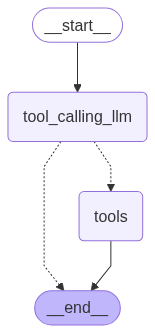

In [16]:
### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Edgess
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
messages=graph.invoke({"messages":"1706.03762"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (hd4mqs32t)
 Call ID: hd4mqs32t
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [18]:
messages=graph.invoke({"messages":"Hi My name is Krish"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi My name is Krish
================================== Ai Message ==================================

Hello Krish! Nice to meet you. How can I assist you today?


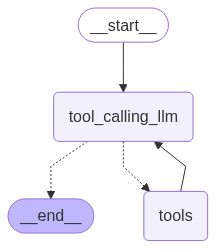

In [19]:
### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Edgess
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
messages=graph.invoke({"messages":"What is the recent AI news and then please tell me the recent research paper on quantum computing?"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent AI news and then please tell me the recent research paper on quantum computing?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (e9jkmkcx8)
 Call ID: e9jkmkcx8
  Args:
    query: recent AI news
  arxiv (wp731xfp5)
 Call ID: wp731xfp5
  Args:
    query: quantum computing recent research
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Artificial Intelligence | Latest News, Photos & Videos - WIRED", "url": "https://www.wired.com/tag/artificial-intelligence/", "content": "### Facing a Changing Industry, AI Activists Rethink Their Strategy\n\n![Demis Hassabis Embraces the Future of Work in the Age of AI](https://media.wired.com/photos/683e039d7fcbfb59910b6706/3:2/w_1280%2Cc_limit/DSC09515.jpg)\n\n### Demis Hassabis Embraces the Future of Wor